In [1]:
from __future__ import unicode_literals, print_function, division

In [2]:
from io import open
import unicodedata
import string
import re
import random
import sconce
import socket
hostname = socket.gethostname()
import gensim
from clean_data import * 

In [3]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from masked_cross_entropy import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using CUDA")
    USE_CUDA = True
else:
    USE_CUDA = False

Using CUDA


In [5]:
gensim_w2v = gensim.models.KeyedVectors.load_word2vec_format('./wikipedia-pubmed-and-PMC-w2v.bin', binary=True)


In [6]:
PAD_token = 0
SOS_token = 1
EOS_token = 2
EMBEDDING_SIZE = 200
added_count = 0

In [7]:
# Source: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2}
        self.word2count = {"PAD": 1, "SOS": 1, "EOS": 1}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3  # Count PAD, SOS and EOS
        self.trimmed = False
        self.max_len = 0
        self.avg_len = 0

    def addSentence(self, sentence):
        local_len = 0
        for word in sentence.split(' '):
            self.addWord(word)
            local_len += 1
        if local_len > self.max_len:
            self.max_len = local_len
           
        self.avg_len = self.avg_len + local_len

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2}
        self.word2count = {"PAD": 1, "SOS": 1, "EOS": 1}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3  # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [8]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = s.lower().strip()
    s = clean_contractions(s)
    s = clean_special_chars(s)
    s = correct_spelling(s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  
    return s

def add_lower(vocab):
    for word in vocab:
        if word in gensim_w2v and word.lower() not in gensim_w2v:  
            gensim_w2v[word.lower()] = gensim_w2v[word]
            added_count += 1


In [9]:
MAX_LENGTH = 100

def readLangs(lang1, lang2, reverse=False, equal=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s_%s.txt' % (lang1, lang2)).\
        read().strip().split('\n')
    
    print("Adding lower case embeddings... ")
    for l in lines:
        for s in l.split('\t'):
            add_lower(s)
    print("Added %d words to the embedding matrix." % added_count)

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    if equal:
        input_lang = output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
# Filter for q/a with at least MIN_LENGTH chars
MIN_LENGTH = 3
def filterPair(p):
    return len(p[0].split(' ')) >= MIN_LENGTH and \
        len(p[1].split(' ')) >= MIN_LENGTH


def filterPairs(pairs):
    for i, pair in enumerate(pairs):
        p1 = pair[0].split(' ')
        p1 = " ".join(p1[:MAX_LENGTH])
        p2 = pair[1].split(' ')
        p2 = " ".join(p2[:MAX_LENGTH])
        pairs[i] = [p1, p2]
    p = [pair for pair in pairs if filterPair(pair)]
    return p

    #return [pair for pair in pairs if filterPair(pair)]
    #return p


def patch_oov(pairs):
    unk_patched = []  # stores sequences patched with unk token for out-of-vocabulary words 
    for pair in pairs:
        input_seq = pair[0].split(" ")
        output_seq = pair[1].split(" ")
        
        for i, word in enumerate(input_seq):
            if word not in input_lang.word2index:
                input_seq[i] = "PAD"
            
        for i, word in enumerate(output_seq):
            if word not in output_lang.word2index:
                output_seq[i] = "PAD"
        unk_patched.append([" ".join(input_seq), " ".join(output_seq)])
    
    return unk_patched




In [11]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print("Max sentence length", input_lang.max_len)
    print("Avg sentence length", (input_lang.avg_len/len(pairs)))
    
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [12]:
def create_embeddings(embedding_matrix, target_lang, gensim_keyed):
    #0-2 for pad, sos, eos
    embedding_matrix[0] = embedding_matrix[1] = embedding_matrix[2] = torch.ones(EMBEDDING_SIZE)
    words_found = 0
    words_missing = []
    for i in range(3,target_lang.n_words):
        try:
            embedding_matrix[i] = torch.from_numpy(gensim_keyed[target_lang.index2word[i]])
            words_found += 1
        except KeyError as ke:
            embedding_matrix[i] = torch.rand(200)
            words_missing.append(target_lang.index2word[i])
            
    print("words found: %d out of %d in vocab, difference is %d " \
          % (words_found, target_lang.n_words, (words_found-target_lang.n_words)))
    return torch.FloatTensor(embedding_matrix)

In [13]:
MIN_COUNT = 2
input_lang, output_lang, pairs = prepareData('sc', 'sc')
input_lang.trim(MIN_COUNT)
output_lang.trim(MIN_COUNT)

pairs = patch_oov(pairs)
print(random.choice(pairs))

Reading lines...
Adding lower case embeddings... 
Added 0 words to the embedding matrix.
Read 58191 sentence pairs
Trimmed to 58191 sentence pairs
Counting words...
Counted words:
sc 39187
Max sentence length 100
Avg sentence length 57.54513584574934
sc 39187
keep_words 19769 / 39187 = 0.5045
keep_words 19769 / 39187 = 0.5045
['how can i lower my ketones ? my ketone levels have been at a for days . ive take a ton of insulin and am drinking water PAD . i do not want to go to the hospital but i dont think there is any other choice . thanks PAD i know you are right ! if they arent down in the morning i will go ', 'how can i lower my ketones ? my ketone levels have been at a for days . ive take a ton of insulin and am drinking water PAD . i do not want to go to the hospital but i dont think there is any other choice . thanks PAD i know you are right ! if they arent down in the morning i will go ']


In [14]:
# embedding matrix
embeddings_matrix = torch.zeros(input_lang.n_words, EMBEDDING_SIZE)
embeddings_matrix = create_embeddings(embeddings_matrix, input_lang, gensim_w2v)
print(embeddings_matrix.size())
print(embeddings_matrix[0])

print(embeddings_matrix[4])


words found: 17052 out of 19772 in vocab, difference is -2720 
torch.Size([19772, 200])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
tensor([ 2.1662

In [15]:
# Helpers -- Prepare data for training
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    # indexes.append(EOS_token) doing that in indexesFromSentence
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
# Batching 

def get_batch(batch_size):
    input_seqs = []
    target_seqs = []
    
    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexesFromSentence(input_lang, pair[0]))
        target_seqs.append(indexesFromSentence(output_lang, pair[1]))
        
    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]
    
    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

In [17]:
# Encoder (LSTM)

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,pre_trained_embeddings,
                 n_layers=1, bidirectional=False, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        # Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        #self.batch_size = batch_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding.weight = torch.nn.Parameter(pre_trained_embeddings)

        self.lstm = nn.LSTM(hidden_size, hidden_size, self.n_layers, bidirectional=bidirectional)

    def forward(self, input_seqs, input_lengths, hidden=None):
        # get word embeddings [timesteps x batch_size x hidden_size]
        embedded = self.embedding(input_seqs) 
        embedded = self.dropout(embedded)

        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)  # pack the sequence
        output, hidden = self.lstm(packed)
        
        output, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(output)  # unpack (back to padded)
        return output, hidden

    def init_hidden(self):
        #directions = 2 if self.bidirectional else 1
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [19]:
# Attention class, different options
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)
        

        # Create variable to store attention energies
        attn_energies = torch.zeros(this_batch_size, max_len, device=device) # B x 1 x S

        # Calculate energies for each encoder output
        for b in range(this_batch_size):
            for i in range(max_len):
                attn_energies[b,i] = self.score(hidden[:, b], encoder_outputs[i,b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1
        # Shape == [1 x Batch_Size x N(1D weights)]
        return F.softmax(attn_energies, -1).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = energy.transpose(0,1)
            energy = self.other.mm(energy)
            return energy


In [20]:
# Decoder

In [21]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, pre_trained_embeddings, n_layers=1, dropout=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Parameters
        # 2 * encoder_hidden_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = dropout
        self.n_layers = n_layers
        
        # Layers
        self.embedding = nn.Embedding(self.output_size, EMBEDDING_SIZE)
        #self.embedding.weight = torch.nn.Parameter(pre_trained_embeddings)

        self.dropout = nn.Dropout(self.dropout)
        self.attn_model = attn_model
        #self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.concat = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.lstm = nn.LSTM(EMBEDDING_SIZE, self.hidden_size, self.n_layers)
        self.out = nn.Linear(self.hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Run this one-step at a time
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = embedded.view(1, batch_size, EMBEDDING_SIZE) # S=1 x B x N
        embedded = self.dropout(embedded)


        # Combine embedded input word and last context, run through RNN
        rnn_output, hidden = self.lstm(embedded, last_hidden)
        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output, encoder_outputs)

        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # B x S=1 x N
        #print("Context size: ", context.size())
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        # Loung eq.5
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Loung eq.6
        o = self.out(concat_output)
        output = F.log_softmax(o, 1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights


In [22]:
"""
encoder_test = EncoderRNN(10, 10, n_layers=2).cuda()
decoder_test = AttnDecoderRNN('concat', 10, 10, 2).cuda()
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
print("Hidden: ", encoder_hidden.size())
word_input = torch.LongTensor([1, 2, 3]).cuda()
#word_input = word_input.cuda()

encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)
print("enc: ", encoder_outputs.size())

word_input = torch.LongTensor([1, 2, 3]).cuda()
#word_input = word_input.cuda()

decoder_attns = torch.zeros(1, 3, 3).cuda()
decoder_hidden = encoder_hidden


decoder_context = torch.zeros(1, decoder_test.hidden_size)

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_input[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden[0].size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).data"""

'\nencoder_test = EncoderRNN(10, 10, n_layers=2).cuda()\ndecoder_test = AttnDecoderRNN(\'concat\', 10, 10, 2).cuda()\nprint(encoder_test)\nprint(decoder_test)\n\nencoder_hidden = encoder_test.init_hidden()\nprint("Hidden: ", encoder_hidden.size())\nword_input = torch.LongTensor([1, 2, 3]).cuda()\n#word_input = word_input.cuda()\n\nencoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)\nprint("enc: ", encoder_outputs.size())\n\nword_input = torch.LongTensor([1, 2, 3]).cuda()\n#word_input = word_input.cuda()\n\ndecoder_attns = torch.zeros(1, 3, 3).cuda()\ndecoder_hidden = encoder_hidden\n\n\ndecoder_context = torch.zeros(1, decoder_test.hidden_size)\n\nfor i in range(3):\n    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_input[i], decoder_context, decoder_hidden, encoder_outputs)\n    print(decoder_output.size(), decoder_hidden[0].size(), decoder_attn.size())\n    decoder_attns[0, i] = decoder_attn.squeeze(0).data'

In [23]:
# Functions to monitor training
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Parameters & Config


In [35]:
# Parameters

attn_model = 'concat'
encoder_hidden_size = 200
decoder_hidden_size = 2*encoder_hidden_size
n_layers = 2
dropout = 0.1
batch_size = 8

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epochs = 50
epoch = 0
plot_every = 10
print_every = 5
evaluate_every = 10

# Initialize models
encoder = EncoderRNN(input_lang.n_words, encoder_hidden_size, embeddings_matrix, n_layers,
                     dropout=dropout,  bidirectional=True)
decoder = AttnDecoderRNN(attn_model, decoder_hidden_size, output_lang.n_words,
                         embeddings_matrix, n_layers, dropout=dropout)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()



# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [36]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, n_layers=1, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = torch.LongTensor([SOS_token] * batch_size)
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    
    decoder_hidden = decoder_hidden[0].view(n_layers, batch_size, decoder_hidden_size), \
                 decoder_hidden[1].view(n_layers, batch_size, decoder_hidden_size)
    max_target_length = max(target_lengths)
    all_decoder_outputs = torch.zeros(max_target_length, batch_size, decoder.output_size)

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, context, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(),  # -> batch x seq
        target_batches.transpose(0, 1).contiguous(),  # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    # returns Total norm of the parameters (viewed as a single vector)
    ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)  
    dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data.item(), ec, dc

In [37]:
def evaluate(input_seq, batch_size =1, max_length=MAX_LENGTH):
    input_lengths = [len(input_seq)]
    input_seqs = [indexesFromSentence(input_lang, input_seq)]
    
    
    input_padded = [pad_seq(s, len(input_seq)) for s in input_seqs]
    input_batches = torch.LongTensor(input_seqs).transpose(0, 1)
    if USE_CUDA:
        input_batches = input_batches.cuda()
        
    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)
    
    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    decoder_input = torch.LongTensor([SOS_token])  # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers]  # Use last (forward) hidden state from encoder
    decoder_hidden = decoder_hidden[0].view(n_layers, batch_size, decoder_hidden_size), \
                 decoder_hidden[1].view(n_layers, batch_size, decoder_hidden_size)
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(input_lengths[0]+1, input_lengths[0]+1)
    
    # Run through decoder
    for di in range(input_lengths[0]):
        decoder_output, context, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data
        
        print(decoder_output.data)
        # Choose top word from output
        topv, topi = decoder_output.squeeze(0).topk(1)
        ni = topi.item()
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = torch.LongTensor([ni])
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [38]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

In [39]:
import io
import torchvision
from PIL import Image
import visdom
vis = visdom.Visdom()

def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

In [40]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

In [32]:
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
    win = 'evaluted (%s)' % hostname
    text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
    vis.text(text, win=win, opts={'title': win})

In [ ]:
evaluate_randomly()

/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


2m 17s (- 20m 38s) (5 10%) 9.8638
4m 28s (- 17m 54s) (10 20%) 9.5845
tensor([[-9.6530, -9.8907, -9.3863,  ..., -9.8919, -9.8712, -9.9105]],
       device='cuda:0')
tensor([[-9.5375, -9.9083, -9.1445,  ..., -9.8911, -9.8861, -9.8945]],
       device='cuda:0')
tensor([[-9.4063, -9.9263, -8.8571,  ..., -9.8955, -9.9008, -9.8741]],
       device='cuda:0')
tensor([[-9.2819, -9.9435, -8.5684,  ..., -9.9015, -9.9113, -9.8579]],
       device='cuda:0')
tensor([[-9.1747, -9.9601, -8.3090,  ..., -9.9074, -9.9173, -9.8477]],
       device='cuda:0')
tensor([[-9.0875, -9.9759, -8.0938,  ..., -9.9127, -9.9200, -9.8421]],
       device='cuda:0')
tensor([[-9.0191, -9.9901, -7.9251,  ..., -9.9174, -9.9208, -9.8395]],
       device='cuda:0')
tensor([[ -8.9667, -10.0021,  -7.7975,  ...,  -9.9214,  -9.9205,  -9.8385]],
       device='cuda:0')
tensor([[ -8.9271, -10.0117,  -7.7030,  ...,  -9.9249,  -9.9197,  -9.8383]],
       device='cuda:0')
tensor([[ -8.8973, -10.0193,  -7.6336,  ...,  -9.9276,  -9.9188,

tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device=

tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device=

tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device=

tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device='cuda:0')
tensor([[ -8.8059, -10.0439,  -7.4325,  ...,  -9.9365,  -9.9142,  -9.8401]],
       device=

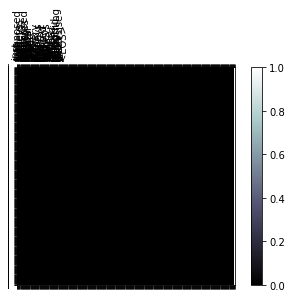

6m 58s (- 16m 17s) (15 30%) 7.9520
9m 9s (- 13m 43s) (20 40%) 6.6069
tensor([[ -6.6861, -10.5145,  -4.9980,  ..., -10.4909, -10.2627, -10.5836]],
       device='cuda:0')
tensor([[ -6.1255, -11.3751,  -3.9697,  ..., -11.3637, -11.0618, -11.5290]],
       device='cuda:0')
tensor([[ -6.0671, -11.5636,  -3.8627,  ..., -11.5858, -11.2702, -11.7643]],
       device='cuda:0')
tensor([[ -6.0615, -11.5862,  -3.8553,  ..., -11.6197, -11.3012, -11.7967]],
       device='cuda:0')
tensor([[ -6.0610, -11.5899,  -3.8551,  ..., -11.6260, -11.3066, -11.8025]],
       device='cuda:0')
tensor([[ -6.0609, -11.5908,  -3.8552,  ..., -11.6275, -11.3077, -11.8039]],
       device='cuda:0')
tensor([[ -6.0609, -11.5910,  -3.8553,  ..., -11.6279, -11.3081, -11.8043]],
       device='cuda:0')
tensor([[ -6.0609, -11.5911,  -3.8553,  ..., -11.6280, -11.3082, -11.8044]],
       device='cuda:0')
tensor([[ -6.0609, -11.5911,  -3.8553,  ..., -11.6281, -11.3083, -11.8045]],
       device='cuda:0')
tensor([[ -6.0609, -11

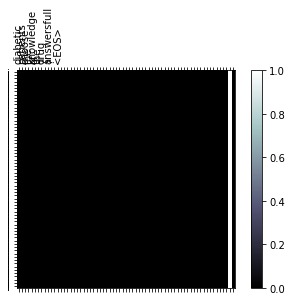

11m 12s (- 11m 12s) (25 50%) 6.3472
13m 22s (- 8m 55s) (30 60%) 6.1953
tensor([[ -5.3123, -13.0989,  -3.9758,  ..., -13.0073, -12.7398, -13.1247]],
       device='cuda:0')
tensor([[ -5.2901, -13.4069,  -3.9800,  ..., -13.2874, -13.0495, -13.3865]],
       device='cuda:0')
tensor([[ -5.2868, -13.4290,  -3.9915,  ..., -13.3045, -13.0677, -13.3981]],
       device='cuda:0')
tensor([[ -5.2862, -13.4311,  -3.9934,  ..., -13.3064, -13.0693, -13.3993]],
       device='cuda:0')
tensor([[ -5.2861, -13.4314,  -3.9937,  ..., -13.3067, -13.0695, -13.3995]],
       device='cuda:0')
tensor([[ -5.2860, -13.4314,  -3.9938,  ..., -13.3067, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9938,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9938,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9938,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -

tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device=

tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device=

tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device=

tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device=

tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device='cuda:0')
tensor([[ -5.2860, -13.4313,  -3.9939,  ..., -13.3068, -13.0695, -13.3996]],
       device=

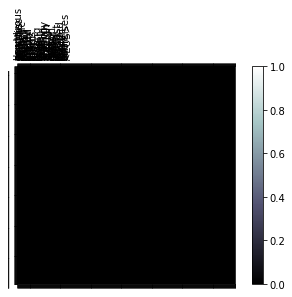

15m 57s (- 6m 50s) (35 70%) 6.3320
17m 49s (- 4m 27s) (40 80%) 6.2153
tensor([[ -5.1995, -13.8539,  -4.0019,  ..., -13.7480, -13.4776, -13.8779]],
       device='cuda:0')
tensor([[ -5.1761, -13.9735,  -4.0026,  ..., -13.8312, -13.6058, -13.9414]],
       device='cuda:0')
tensor([[ -5.1705, -13.9796,  -4.0028,  ..., -13.8310, -13.6144, -13.9385]],
       device='cuda:0')
tensor([[ -5.1694, -13.9801,  -4.0026,  ..., -13.8307, -13.6153, -13.9379]],
       device='cuda:0')
tensor([[ -5.1693, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1693, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -1

tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device=

tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device=

tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device=

tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device=

tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device=

tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
tensor([[ -5.1692, -13.9801,  -4.0026,  ..., -13.8307, -13.6155, -13.9378]],
       device='cuda:0')
> type diabetes when a teen and having a massive party tomorrow night ? PAD night is the night following finishing my final exams . i dont drink so thats settled and ill hope not to get any PA

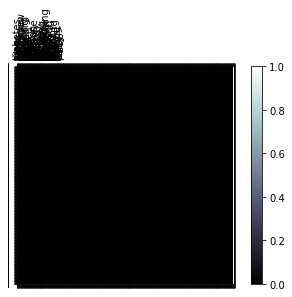

20m 29s (- 2m 16s) (45 90%) 6.6529
22m 40s (- 0m 0s) (50 100%) 6.3547
tensor([[ -5.0118, -13.9542,  -4.0873,  ..., -13.7576, -13.5105, -14.0306]],
       device='cuda:0')
tensor([[ -5.0018, -14.0347,  -4.1059,  ..., -13.8008, -13.5773, -14.0789]],
       device='cuda:0')
tensor([[ -5.0027, -14.0396,  -4.1126,  ..., -13.8020, -13.5790, -14.0794]],
       device='cuda:0')
tensor([[ -5.0028, -14.0403,  -4.1136,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -1

tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device=

tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device=

tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device=

tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device='cuda:0')
tensor([[ -5.0029, -14.0403,  -4.1137,  ..., -13.8022, -13.5792, -14.0795]],
       device=

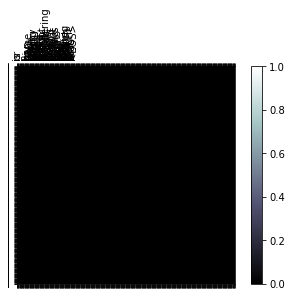

In [41]:
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = get_batch(batch_size)

    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion, n_layers=n_layers
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc
    

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)
        ecs_win = 'encoder grad (%s)' % hostname
        dcs_win = 'decoder grad (%s)' % hostname
        vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
        vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
        eca = 0
        dca = 0

<Figure size 432x288 with 0 Axes>

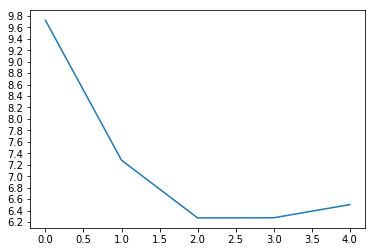

In [42]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [44]:
example = "i am a tourist from india in us.i am diabitic.what type of us food can be suitable for me.?"
output_words, attentions = evaluate(example)
plt.matshow(attentions.numpy())
show_plot_visdom()

KeyError: 'tourist'